# Illustrative example

EVO-SPOTIS - library for recommendation and decision support system based on the stochastic evolutionary algorithm Differential Evolution algorithm and the SPOTIS method

This manual explains the usage of the Python 3 package named `evo_spotis` for the multi-criteria decision support system that gives recommendations applying the SPOTIS multi-criteria decision analysis method using criteria weights determined by the Differential Evolution algorithm based on data and historical rankings for an analogous decision problem.

Import necessary Python modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import the necessary modules and methods from package `evo_spotis`

In [2]:
from evo_spotis.mcda_methods import SPOTIS
from evo_spotis.stochastic_algorithms import DE_algorithm
from evo_spotis.additions import rank_preferences
from evo_spotis import correlations as corrs
from evo_spotis import weighting_methods as mcda_weights

Functions for results visualization.

In [3]:
# Functions for result visualizations
def plot_scatter(data, model_compare):
    """
    Display scatter plot comparing real and predicted ranking.

    Parameters
    -----------
        data: dataframe
        model_compare : list[list]

    Examples
    ----------
    >>> plot_scatter(data. model_compare)
    """
    sns.set_style("darkgrid")
    list_rank = np.arange(1, len(data) + 2, 4)
    list_alt_names = data.index
    for it, el in enumerate(model_compare):
        
        xx = [min(data[el[0]]), max(data[el[0]])]
        yy = [min(data[el[1]]), max(data[el[1]])]

        fig, ax = plt.subplots(figsize=(7, 7))
        ax.plot(xx, yy, linestyle = '--', zorder = 1)

        ax.scatter(data[el[0]], data[el[1]], marker = 'o', color = 'royalblue', zorder = 2)
        for i, txt in enumerate(list_alt_names):
            ax.annotate(txt, (data[el[0]][i], data[el[1]][i]), fontsize = 14, style='italic',
                         verticalalignment='bottom', horizontalalignment='right')

        ax.set_xlabel(el[0], fontsize = 16)
        ax.set_ylabel(el[1], fontsize = 16)
        ax.tick_params(axis='both', labelsize=16)
        ax.set_xticks(list_rank)
        ax.set_yticks(list_rank)

        x_ticks = ax.xaxis.get_major_ticks()
        y_ticks = ax.yaxis.get_major_ticks()

        ax.set_xlim(-1, len(data) + 1)
        ax.set_ylim(0, len(data) + 1)

        ax.grid(True, linestyle = '--')
        ax.set_axisbelow(True)
    
        plt.tight_layout()
        plt.show()


def plot_fitness(BestFitness, MeanFitness):
    """
    Display line plot of best and mean fitness values in each DE iteration.

    Parameters
    ----------
        BestFitness : ndarray
            array with best fitness values for each DE iteration.
        MeanFitness : ndarray
            array with mean fitness values for each DE iteration.

    Examples
    ----------
    >>> plot_fitness(BestFitness, MeanFitness)
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots()
    ax.plot(BestFitness, label = 'Best fitness value')
    ax.plot(MeanFitness, label = 'Mean fitness value')
    ax.set_xlabel('Iterations', fontsize = 15)
    ax.set_ylabel('Fitness value', fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.legend(fontsize = 15)
    plt.tight_layout()
    plt.show()


def plot_rankings(results):
    """
    Display scatter plot comparing real and predicted ranking.

    Parameters
    -----------
        results : dataframe
            Dataframe with columns containing real and predicted rankings.

    Examples
    ---------
    >>> plot_rankings(results)
    """
    model_compare = []
    names = list(results.columns)
    model_compare = [[names[0], names[1]]]
    results = results.sort_values('Real rank')
    sns.set_style("darkgrid")
    plot_scatter(data = results, model_compare = model_compare)


def plot_weights(weights):
    """
    Display scatter plot comparing real and predicted weights

    Parameters
    -----------
        weights : dataframe
            Dataframe with columns containing real and predicted weights.

    Examples
    ----------
    >>> plot_weights(weights)
    """
    sns.set_style("darkgrid")
    step = 1
    list_rank = np.arange(1, len(weights) + 1, step)
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.scatter(x = list_rank, y = weights['Real weights'].to_numpy(), c = '#ff7f0e', marker = 'o', s = 70, label = 'Real weights')
    ax.scatter(x = list_rank, y = weights['DE weights'].to_numpy(), c = 'k', marker = '*', s = 50, label = 'DE weights')
    
    ax.set_xlabel('Criteria', fontsize = 16)
    ax.set_ylabel('Weight value', fontsize = 16)
    ax.set_xticks(list_rank)

    ax.set_xticklabels(list(weights.index))
    ax.tick_params(axis = 'both', labelsize = 16)
    y_ticks = ax.yaxis.get_major_ticks()
    # ax.legend(fontsize = 15, ncol = 2)
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
    ncol=2, mode="expand", borderaxespad=0., fontsize = 15)
    ax.grid(True)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()

## Numerical example of the SPOTIS method application

First, we show the application of the SPOTIS method to a multi-criteria problem from paper Dezert, J., Tchamova, A., Han, D., & Tacnet, J. M. (2020, July). The SPOTIS rank reversal free method for multi-criteria decision-making support. In 2020 IEEE 23rd International Conference on Information Fusion (FUSION) (pp. 1-8). IEEE.

This is car selection MCDA problem. We consider a set of four
cars A1, A2, A3, and A4 as follows:
- A1 = TOYOTA YARIS 69 VVT-i Tendance;
- A2 = SUZUKI SWIFT MY15 1.2 VVT So’City;
- A3 = VOLKSWAGEN POLO 1.0 60 Confortline;
- A4 = OPEL CORSA 1.4 Turbo 100 ch Start/Stop Edition;

We consider the following five criteria for making the choice of the best car to buy:
- C1 is the price (in e) (cost criterion);
- C2 is fuel consumption (in L/km) (cost criterion);
- C3 is the CO2 emission (in g/km) (cost criterion);
- C4 is the fuel tank volume (in L) (profit criterion);
- C5 is the trunk volume (in L) (profit criterion);

In the following code, `matrix` is a decision matrix containing alternatives in rows and criteria in columns. Criteria weights denoting criteria significance provided by decision-maker are included in `weights`. All weights must sum to 1. Criteria types are contained in `types` where 1 represents profit and -1 cost criteria. Min bounds are included in `bounds_min` and max bounds in `bounds_max`. Then we have to create the SPOTIS method object and calculate SPOTIS preference of alternatives `pref`.

In [4]:
matrix = np.array([[15000, 4.3, 99, 42, 737],
                 [15290, 5.0, 116, 42, 892],
                 [15350, 5.0, 114, 45, 952],
                 [15490, 5.3, 123, 45, 1120]])

weights = np.array([0.2941, 0.2353, 0.2353, 0.0588, 0.1765])
types = np.array([-1, -1, -1, 1, 1])
bounds_min = np.array([14000, 3, 80, 35, 650])
bounds_max = np.array([16000, 8, 140, 60, 1300])
bounds = np.vstack((bounds_min, bounds_max))

spotis = SPOTIS()
pref = spotis(matrix, weights, types, bounds)
pref

array([0.47795182, 0.57811819, 0.55574955, 0.58013109])

After SPOTIS preference calculation, we have to rank alternatives according to the preference value `pref` in ascending order because in the SPOTIS algorithm alternative with the lowest preference value is the best option. For this aim, we use `rank_preferences` method from `additions` module provided by `evo_spotis` with `reverse` set to False because we have to sort alternatives ascendingly.

In [5]:
rank = rank_preferences(pref, reverse = False)
rank

array([1, 3, 2, 4])

It can be noted that alternative A1 is the best-scored alternative, followed by A3. The next is A2, and A4 is the last in the ranking.

## Example of mobile phones evaluation using the SPOTIS method and criteria weights identified by EVO-SPOTIS

The 21 evaluation criteria for mobile phones are presented below. Goal represents a criteria type that can be Profit (1) or Cost (-1) The purpose of proposed approach is to identify the values of the weights of these criteria and use them for multi-criteria evaluation of an analogous set of alternatives, for which the weights and ratings are unknown.

In [6]:
criteria_phones = 'criteria_phones.csv'
df_crit = pd.read_csv(criteria_phones, index_col = ('Cj'))
pd.set_option('max_colwidth', None)
df_crit

,Symbol,Name,Explanation,Goal
Cj,,,,
C1,battery_power,Battery power,Total energy a battery can store in one time measured in mAh,1
C2,blue,Blue,Has bluetooth or not,1
C3,clock_speed,Clock speed,Speed at which microprocessor executes instructions,1
C4,dual_sim,Dual sim,Has dual sim support or not,1
C5,fc,Fc (Front camera),Front Camera mega pixels,1
C6,four_g,Four G,Has 4G or not,1
C7,int_memory,Internal memory,Internal Memory in Gigabytes,1
C8,m_dep,Mobile depth,Mobile Depth in cm,-1
C9,mobile_wt,Mobile weight,Weight of mobile phone,-1


Load dataset. In this case, the training dataset and the test dataset will be extracted from data on the first 200 mobile phones from the dataset containing 2000 samples. Be aware that the training dataset must have a large enough size for the algorithm to work effectively, such as 100 samples. The last row of the CSV file contains the criterion types, where 1 is the profit criterion, and -1 is the cost criterion. Convert dataframe to numpy array (ndarray) `whole_matrix` for faster calculations.

In [7]:
filename = 'mobile_phones2000.csv'
data = pd.read_csv(filename)
types = data.iloc[len(data) - 1, :].to_numpy()
df_data = data.iloc[:-1, :]
whole_matrix = df_data.to_numpy()

The SPOTIS method was chosen as a multi-criteria method for evaluating alternatives in this system. For this method, bounds containing minimum and maximum constraints on the performance values of the alternatives with respect to the corresponding criteria have to be determined. This procedure represents the definition of the problem space by the decision-maker. It ensures that there will be no reversal of the ranking of the alternatives when the training and test datasets are evaluated individually. Bounds need not be the de facto minima and maxima of the decision matrix but may be determined by the decision-maker depending on the problem.

In [8]:
# determine bounds of alternatives performances for the SPOTIS method
bounds_min = np.amin(whole_matrix, axis = 0)
bounds_max = np.amax(whole_matrix, axis = 0)
bounds = np.vstack((bounds_min, bounds_max))

Provide the training dataset `X_train` and the test dataset `X_test`. The training dataset is displayed below. The columns contain the names of the criteria, and the rows include the symbols of the alternatives. The last column, named Rank, contains the expert ranking `y_train`.

In [9]:
# load train and test datasets
X_train_df_full = pd.read_csv('train_dataset.csv', index_col='Ai')
X_train_df_full

,$C_{1}$,$C_{2}$,$C_{3}$,$C_{4}$,$C_{5}$,$C_{6}$,$C_{7}$,$C_{8}$,$C_{9}$,$C_{10}$,...,$C_{13}$,$C_{14}$,$C_{15}$,$C_{16}$,$C_{17}$,$C_{18}$,$C_{19}$,$C_{20}$,$C_{21}$,Rank
Ai,,,,,,,,,,,,,,,,,,,,,
$A_{1}$,1923.0,0.0,0.5,1.0,7.0,0.0,46.0,0.5,191.0,1.0,...,1759.0,1489.0,10.0,9.0,3.0,1.0,1.0,1.0,1.0,495
$A_{2}$,633.0,1.0,2.2,0.0,0.0,1.0,49.0,0.1,139.0,8.0,...,1009.0,3560.0,11.0,1.0,16.0,1.0,1.0,1.0,2.0,190
$A_{3}$,1236.0,0.0,0.9,1.0,2.0,1.0,57.0,0.1,188.0,1.0,...,809.0,1406.0,14.0,12.0,20.0,1.0,0.0,1.0,0.0,359
$A_{4}$,781.0,0.0,1.1,0.0,2.0,0.0,38.0,0.4,198.0,5.0,...,1674.0,3508.0,13.0,8.0,5.0,0.0,0.0,1.0,3.0,1539
$A_{5}$,1456.0,1.0,0.5,1.0,7.0,0.0,7.0,0.4,105.0,5.0,...,1104.0,1587.0,6.0,5.0,20.0,1.0,0.0,1.0,1.0,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
$A_{1596}$,1975.0,1.0,1.9,1.0,2.0,0.0,31.0,0.9,151.0,1.0,...,1607.0,3022.0,13.0,5.0,19.0,0.0,0.0,1.0,3.0,818
$A_{1597}$,589.0,1.0,0.5,0.0,1.0,1.0,59.0,0.7,146.0,8.0,...,1858.0,362.0,16.0,10.0,6.0,1.0,1.0,1.0,0.0,143
$A_{1598}$,1829.0,1.0,0.5,0.0,0.0,1.0,15.0,0.4,160.0,5.0,...,1267.0,2080.0,16.0,11.0,12.0,1.0,0.0,1.0,2.0,640


In [10]:
X_train_df = X_train_df_full.drop(['Rank'], axis = 1)

X_train = X_train_df.to_numpy()
y_train = X_train_df_full['Rank'].to_numpy()

In [11]:
X_test_df_full = pd.read_csv('test_dataset.csv', index_col='Ai')
X_test_df_full

,$C_{1}$,$C_{2}$,$C_{3}$,$C_{4}$,$C_{5}$,$C_{6}$,$C_{7}$,$C_{8}$,$C_{9}$,$C_{10}$,...,$C_{13}$,$C_{14}$,$C_{15}$,$C_{16}$,$C_{17}$,$C_{18}$,$C_{19}$,$C_{20}$,$C_{21}$,Rank
Ai,,,,,,,,,,,,,,,,,,,,,
$A_{1}$,1646.0,0.0,2.5,0.0,3.0,1.0,25.0,0.6,200.0,2.0,...,1608.0,686.0,8.0,6.0,11.0,1.0,1.0,0.0,0.0,274
$A_{2}$,1182.0,0.0,0.5,0.0,7.0,1.0,8.0,0.5,138.0,8.0,...,986.0,2563.0,19.0,17.0,19.0,1.0,0.0,0.0,2.0,326
$A_{3}$,1972.0,0.0,2.9,0.0,9.0,0.0,14.0,0.4,196.0,7.0,...,952.0,1316.0,8.0,1.0,8.0,1.0,1.0,0.0,1.0,331
$A_{4}$,989.0,1.0,2.0,0.0,4.0,0.0,17.0,0.2,166.0,3.0,...,1394.0,3892.0,18.0,7.0,19.0,1.0,1.0,0.0,3.0,234
$A_{5}$,615.0,1.0,0.5,1.0,7.0,0.0,58.0,0.5,130.0,5.0,...,1958.0,1906.0,14.0,5.0,5.0,1.0,0.0,0.0,1.0,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
$A_{396}$,1379.0,0.0,0.5,1.0,1.0,0.0,19.0,0.3,134.0,8.0,...,671.0,3912.0,11.0,2.0,19.0,0.0,1.0,1.0,3.0,208
$A_{397}$,991.0,0.0,2.0,0.0,2.0,1.0,12.0,0.3,158.0,5.0,...,1678.0,2014.0,11.0,9.0,10.0,1.0,0.0,0.0,2.0,361
$A_{398}$,1044.0,0.0,1.8,0.0,4.0,1.0,12.0,0.7,104.0,6.0,...,1263.0,1794.0,18.0,7.0,19.0,1.0,1.0,1.0,1.0,121


In [12]:
X_test_df = X_test_df_full.drop(['Rank'], axis = 1)

X_test = X_test_df.to_numpy()
y_test = X_test_df_full['Rank'].to_numpy()

The performance dataset represents the training features `X_train`, and the ranking of alternatives represents the target variable `y_train`. The expert weights are usually implicit, and the DE algorithm generates them based on the known ranking of the training set. In this case, the expert weights determined by the Entropy method `entropy_weighting` from module named `weighting_methods` are provided for comparison with the weights generated by the algorithm for research purposes.

In [13]:
# real weights
train_weights = mcda_weights.entropy_weighting(X_train)
# Load symbols of criteria in columns 
cols = [r'$C_{' + str(y) + '}$' for y in range(1, data.shape[1] + 1)]
list_alt_names = [r'$A_{' + str(i) + '}$' for i in range(1, X_test_df.shape[0] + 1)]
list_alt_names_train = [r'$A_{' + str(i) + '}$' for i in range(1, X_train_df.shape[0] + 1)]

Run the DE algorithm. The class containing this algorithm and all the methods needed to run it are included in the de.py file. You can decide if you want to display the best value of the fitness function in each iteration of the algorithm by setting the `verbose` parameter to `True` (the default setting) or choosing not to display it by setting verbose to False. The setting parameters of the DE algorithm are initialized in the `__init__` method that initializes an object of de_algorithm. The DE algorithm takes as arguments decision matrix with training samples `X_train`, an expert ranking determined for the training dataset `y_train`, criteria types `types`, and bounds `bounds`. The DE algorithm returns generated weights (`BestSolution` of the best individual in population), the best and average fitness function values in successive DE iterations.

In [14]:
# create object of DE algorithm
de_algorithm = DE_algorithm()
# run DE algorithm
BestSolution, BestFitness, MeanFitness = de_algorithm(X_train, y_train, types, bounds, verbose = False)

Check the results of the algorithm. Skip the following step if you do not have the reference expert weights for the training dataset.

Weights correlation:  0.9999982964298612


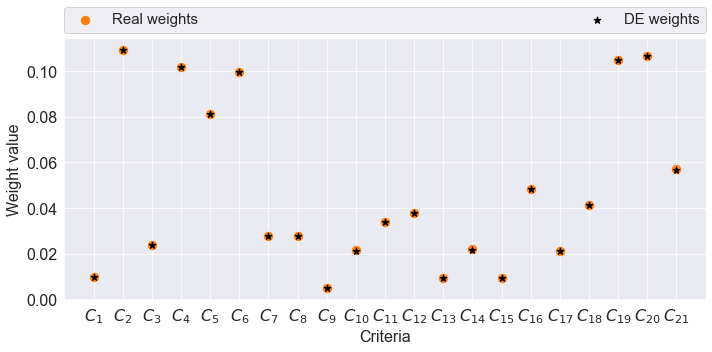

In [15]:
# Results
weights = pd.DataFrame(index = cols)
weights['Real weights'] = train_weights
weights['DE weights'] = BestSolution
weights = weights.rename_axis('Cj')

print('Weights correlation: ', corrs.pearson_coeff(train_weights, BestSolution))
plot_weights(weights)

Save and visualize the results of the best and mean fitness function values in subsequent iterations.

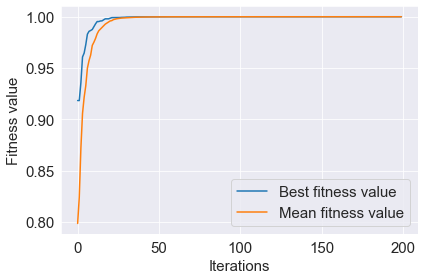

In [16]:
fitness_best = pd.DataFrame()
fitness_best['Best fitness value'] = BestFitness

fitness_mean = pd.DataFrame()
fitness_mean['Mean fitness value'] = MeanFitness

plot_fitness(BestFitness, MeanFitness)

The final stage of this research involves determining the ranking `y_pred` for mobile phones from the test dataset `X_test` using the criterion weights determined by the DE algorithm `BestSolution` - since the values represent the position of the best individual in the population after running the evolutionary algorithm, represent the criterion weights). Next, both rankings, namely real `y_test` and predicted `y_pred` are compared using the Spearman rank correlation coefficient. A comparison of the rankings to determine their convergence is visualized in the chart.

Rankings consistency:  0.9999988749929687


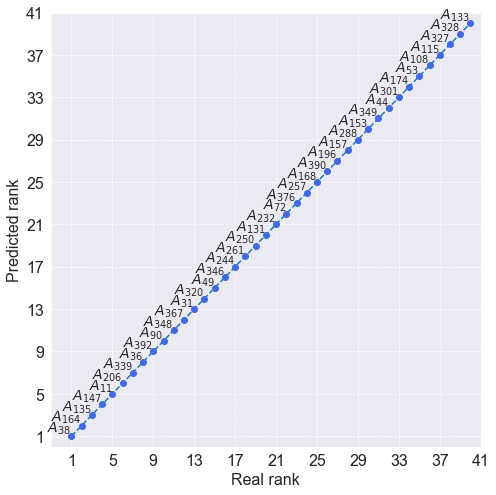

In [17]:
# Ranking
spotis = SPOTIS()
pref = spotis(X_test, BestSolution, types, bounds)
y_pred = rank_preferences(pref, reverse = False)
print('Rankings consistency: ', corrs.spearman(y_test, y_pred))

results = pd.DataFrame(index = list_alt_names)
results['Real rank'] = y_test
results['Predicted rank'] = y_pred
results = results.sort_values(by=['Real rank'])

plot_rankings(results.iloc[:40,:])